# Lab 1: Spike Sorting

**STATS320: Machine Learning Methods for Neural Data Analysis**

_Stanford University. Winter, 2021._

---

**Team Name:** Team 4 (un4gettable)

**Team Members:** Tom McIlwain, Julia Costacurta, Brigitte Schmittlein, Gongqi Li

*Due: 11:59pm Thursday, Jan 21, 2021 via GradeScope (see below)*


In this lab you'll build a basic spike sorting algorithm for electrophysiological recordings like those you might collect with a Neuropixels probe. The model is inspired by [Kilosort](https://github.com/MouseLand/Kilosort), a popular spike sorting algorithm. We'll fit the model to synthetic data simulated with "eMouse," a Kilosort utility for testing spike sorting algorithms on realistic data with ground truth spike times.

## Instructions
Make a copy of this notebook and share it amongst yourselves. Fill in your names and your chosen team name above! You won't be graded on your team name, but you might be judged. (Just kidding!)

Complete and run the code cells below to preprocess the data, implement the spike sorting model described in class, and produce some plots.

The problems in Parts 1-3 ask you to fill in a few lines of code. Some problems are one-liners, which we denote by
```
result = ...     # YOUR CODE HERE
```
It's ok if you split your answer into more than one line. Other problems will almost surely need a few lines of code, which we denote by
```
###
# This block should do a thing.
# YOUR CODE BELOW
#

result = ...
#
###
```
We have a few asserts in the code so that you can check you're getting the expected result. Don't change the output variable names or the subsequent code won't run!

Part 4 asks you to discuss the results. Respond to these questions in text cells.

### Submission
At the end, you'll submit both a PDF and a .ipynb file via GradeScope. It's due at **11:59pm Thursday, Jan 21.**

# Environment Setup

In [ ]:
# First, import necessary libraries.
import numpy as np
import numpy.random as npr
from scipy.io import loadmat 
import scipy.signal as signal
from scipy.ndimage import gaussian_filter1d
from sklearn.neighbors import NearestNeighbors
from tqdm.auto import trange
from copy import deepcopy
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import scipy.stats as stats

import seaborn as sns
sns.set_context("notebook")

## Download the synthetic data
This data was simulated with [eMouse](https://github.com/MouseLand/Kilosort/tree/main/eMouse_drift), a Kilosort utility for generating semi-synthetic data.  It's only semi-synthetic because the spike waveforms are taken from real recordings with manually curated spikes.  The spike timing and noise are all drawn from known distributions though.

In [ ]:
%%capture
!wget -nc https://www.dropbox.com/s/tq0auevkswaa09y/sim_binary.imec.ap.bin
!wget -nc https://www.dropbox.com/s/j0xcqk7v9n0fzc7/eMouseGroundTruth.mat

In [ ]:
# Load the data. It's stored a binary file of int16's
sample_freq = 30000             # sampling frequency
spike_width = 81                # width of a spike, in samples
plot_slice = slice(0, 6000)     # 200ms window of frames to plot
num_channels = 64               # number of channels on the probe

raw_data = np.fromfile("sim_binary.imec.ap.bin", dtype=np.int16).reshape(-1, num_channels)
raw_data = raw_data.T           # Transpose to be consisten with notes
_, num_samples = raw_data.shape
timestamps = np.arange(num_samples) / sample_freq

In [ ]:
#@title Define some helper functions for plotting (run this cell)
def plot_data(timestamps,
              data, 
              plot_slice=plot_slice, 
              true_labels=None, 
              true_times=None,
              unit_channels=None,
              spike_width=spike_width,
              scale=10,
              figsize=(12, 9),
              cmap="jet"):
    n_channels, n_samples = data.shape
    cmap = get_cmap(cmap) if isinstance(cmap, str) else cmap
    
    plt.figure(figsize=figsize)
    plt.plot(timestamps[plot_slice], 
             data.T[plot_slice] - scale * np.arange(n_channels), 
             '-k', lw=1)
    
    if not any(x is None for x in [true_labels, true_times, unit_channels]):
        # Plot the ground truth spikes and assignments
        n_units = true_labels.max()
        in_slice = (true_times >= plot_slice.start) & (true_times < plot_slice.stop)
        labels = true_labels[in_slice]
        times = true_times[in_slice]
        for i in range(n_units):
            i_channels = unit_channels[i]
            for t in times[labels == i + 1]:
                window = slice(t - spike_width // 2, t + spike_width // 2)
                plt.plot(timestamps[window], 
                         data.T[window, i_channels] - scale * np.arange(n_channels)[i_channels],
                         color=cmap(i / (n_units-1)),
                         alpha=0.5,
                         lw=2)
                
    plt.yticks(-scale * np.arange(1, n_channels+1, step=2), 
            np.arange(1, n_channels+1, step=2) + 1)
    plt.xlabel("time [s]")
    plt.ylabel("channel")
    plt.xlim(timestamps[plot_slice.start], timestamps[plot_slice.stop])
    plt.ylim(-scale * n_channels, scale)


def plot_templates(templates, 
                   indices,
                   scale=0.1,
                   n_cols=8,
                   panel_height=6,
                   panel_width=1.25,
                   colors=('k',),
                   label="neuron"):
    n_subplots = len(indices)
    n_cols = min(n_cols, n_subplots)
    n_rows = int(np.ceil(n_subplots / n_cols))

    fig, axs = plt.subplots(n_rows, n_cols, 
                            figsize=(panel_width * n_cols, panel_height * n_rows),
                            sharex=True, sharey=True)
    
    n_units, n_channels, spike_width = templates.shape
    timestamps = np.arange(-spike_width // 2, spike_width//2) / sample_freq
    for i, (ind, ax) in enumerate(zip(indices, np.ravel(axs))):
        color = colors[i % len(colors)]
        ax.plot(timestamps * 1000, 
                templates[ind].T - scale * np.arange(n_channels), 
                '-', color=color, lw=1)
        
        ax.set_title("{} {:d}".format(label, ind + 1))
        ax.set_xlim(timestamps[0] * 1000, timestamps[-1] * 1000)
        ax.set_yticks(-scale * np.arange(n_channels+1, step=4))
        ax.set_yticklabels(np.arange(n_channels+1, step=4) + 1)
        ax.set_ylim(-scale * n_channels, scale)

        if i // n_cols == n_rows - 1:
            ax.set_xlabel("time [ms]")
        if i % n_cols == 0:
            ax.set_ylabel("channel")

        # plt.tight_layout(pad=0.1)


## Plot the raw data
It's a 64-dimensional time series of voltage measurements for each channel in units of microvolts ($\mu$V). Here we plot a 200ms window of data. The `scale` parameter specifies the spacing between channels in the same units as the data.  For this synthetic data, the noise is on the order of 10-20$\mu$V, and the spikes are on the order of 100$\mu$V. 

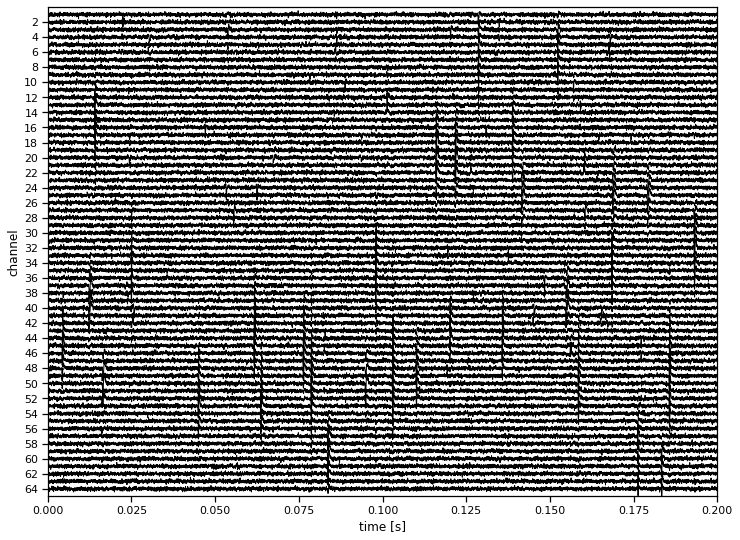

In [ ]:
plot_data(timestamps, raw_data, scale=100)

# Part 1: Preprocessing the data

## Problem 1a: Bandpass filtering
First we will bandpass filter each channel from 300Hz to 2kHz to isolate spiking content. We'll use a 10th order Butterworth filter.

Use `signal.butter` and `signal.sosfilt` to do this (note that `signal` is an alias for `scipy.signal`; see above). Try calling `help(signal.butter)` or Googling it for more information on the function signature and outputs. The `sample_freq` is specified above.

Text(0.5, 1.0, 'Butterworth filter frequency response')

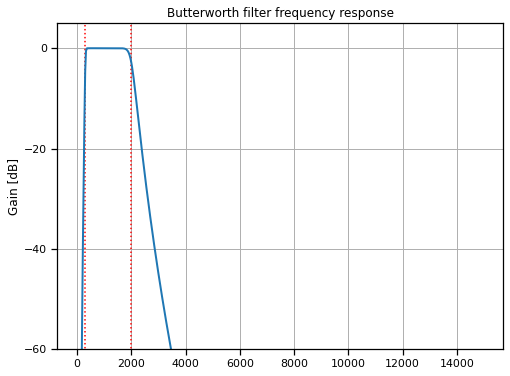

In [ ]:
# Construct a Butterworth bandpass filter.
N = 10
Wn = [300/(0.5*sample_freq), 2000/(0.5*sample_freq)]
sos = signal.butter(N, Wn, btype='bandpass', output='sos')  # YOUR CODE HERE

# This function evaluates the filter response
# at a grid of input frequencies from 0 to the Nyquist frequency
# (1/2 the sampling frequency). The response is given
# as a complex number for each input frequency, where the square 
# of the magnitude is the power at that frequency.
freqs, response = signal.sosfreqz(sos, fs=sample_freq)

# convert the response to decibels and truncate lower end.
# (see, e.g., https://en.wikipedia.org/wiki/Decibel)
response_db = 20 * np.log10(np.maximum(np.abs(response), 1e-5))

# Plot the response.
plt.figure(figsize=(8, 6))
plt.plot(freqs, response_db, lw=2)
plt.vlines([300, 2000], *plt.ylim(), colors='r', ls=':')
plt.ylim(-40, 5)
plt.grid(True)
plt.yticks([0, -20, -40, -60])
plt.ylabel('Gain [dB]')
plt.title('Butterworth filter frequency response')

The next cell applies the filter to the raw data using `signal.sosfilt`.

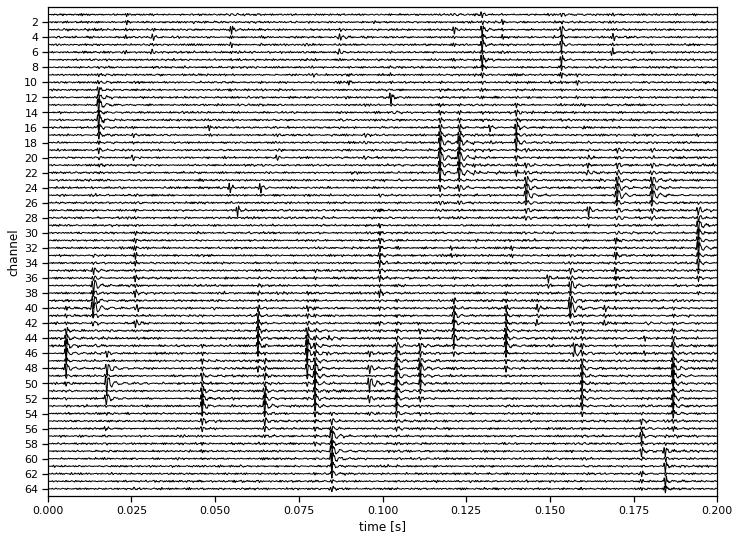

In [ ]:
filtered_data = signal.sosfilt(sos, raw_data, axis=1)
# Plot the result. It should be much cleaner than the raw data.
plot_data(timestamps, filtered_data, scale=100)

## Problem 1b: Decorrelate and standardize the signal

Bandpass filtering effectively centered the data for us (think about why that is), but there are still instantaneous noise correlations between the channels that will invalidate our modeling assumptions below.  We'll try to counteract that here.

Let $x \in \mathbb{R}^C$ denote a random variable denoting a vector of voltage measurements across the $C$ channels. Let $\mathrm{Cov}(x) = \Sigma$ denote the (symmetric) covariance matrix of $x$, and define $\tilde{x} = \Sigma^{-1/2} x$. Then $\mathrm{Cov}(\tilde{x}) = \Sigma^{-1/2} \Sigma (\Sigma^{-1/2})^\top = I$. Multiplying by the inverse square root of the covariance yields a random variable with uncorrelated channels and unit variance along each channel.

We'll use an empirical estimate of the covariance matrix instead. Let $\hat{\Sigma} = \frac{1}{T} \sum_{t=1}^T x_t x_t^\top$ denote the empirical covariance matrix, where $x_t$ is the vector of voltage measurements at time $t$ across all channels. $\hat{\Sigma} = U S V^T$ denote its signal value decomposition.  Since the covariance matrix is symmetric, $U = V$.  The inverse square root is given by,
\begin{align}
\hat{\Sigma}^{-1/2} = V S^{-1/2} V^T.
\end{align}

We will call the transformed data $\tilde{x}_t = \hat{\Sigma}^{-1/2} x_t$ the `data` for short, since it's what we'll be working with from here on.



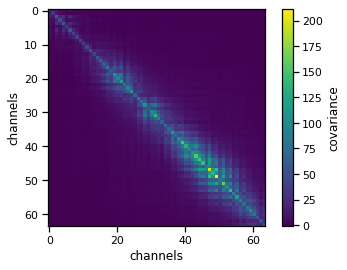

In [ ]:
cov = (1/np.size(filtered_data, axis=1)) * filtered_data @ np.transpose(filtered_data)
# cov = np.cov(filtered_data)  # YOUR CODE HERE
plt.figure()
plt.imshow(cov)
plt.xlabel("channels")
plt.ylabel("channels")
plt.colorbar(label="covariance")

In [ ]:
# Use the SVD to construct the transformation matrix
U, S, VT = np.linalg.svd(cov)
inverse_sqrt_cov = np.dot(U, np.dot((np.diag(S**(-0.5))), VT)) # YOUR CODE HERE

# Multiply the filtered data by the inverse square root of the covariance
data = inverse_sqrt_cov @ filtered_data

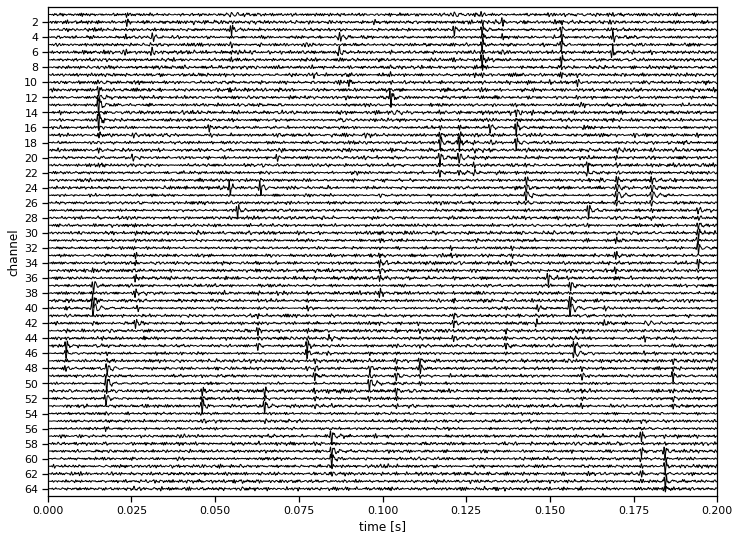

In [ ]:
# Plot the standardized data. 
# Note that the scale is an order of magnitude smaller!
plot_data(timestamps, data, scale=10)

In [ ]:
# Cleanup: remove the filtered data since we no longer need it.
del filtered_data

# Part 2: Find putative spikes

## Problem 2a: Find negative peaks in the data

We're looking for peaks in the negative voltage for each channel. The peaks should stand out from the noise---a reasonable threshold is 4 standard deviations---and they should be well separted---a reasonable distance is 5ms.  Use the `signal.find_peaks` function to extract negative peaks for each channel.

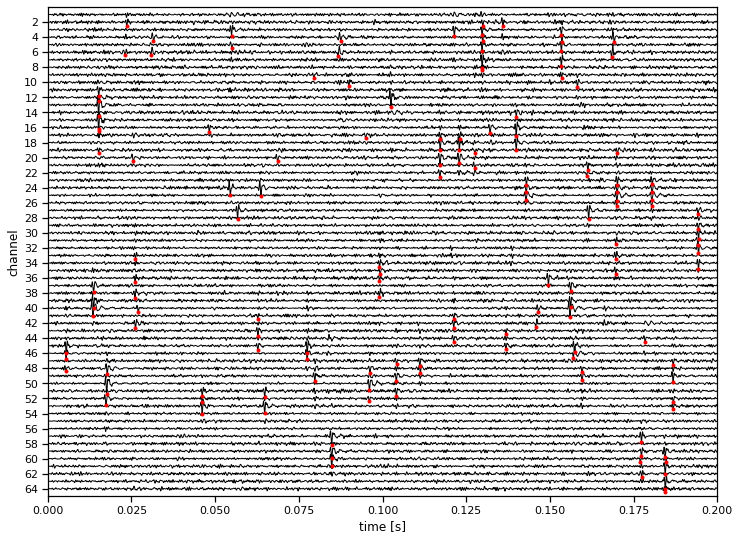

In [ ]:
# Use scipy.signal.find_peaks to find candidate spike times.
distance_ms = 0.005     # time between spikes (in seconds)
distance_samples = distance_ms * sample_freq
height = 4              # standard deviations to define a spike
per_ch_spike_inds = []  # list of arrays of spike indices for each channel

for ch in trange(num_channels):
    # Find the peaks in the negative voltage data for channel `ch`.

    ch_spike_inds, _ = signal.find_peaks(-data[ch], height, distance=distance_samples)   # YOUR CODE HERE

    per_ch_spike_inds.append(ch_spike_inds)

plot_data(timestamps, data)
for ch, ch_spike_inds in enumerate(per_ch_spike_inds):
    plt.plot(timestamps[ch_spike_inds], data[ch, ch_spike_inds] - 10 * ch, 'r.',)

## Problem 2b: Combine spike times that are nearly coincident across channels

We'll do this in a few steps:

1. Count the number of spikes in each time bin with `np.histogram` applied to the concatenated `per_channel_spike_inds`.
2. Smooth the `total_spike_counts` with `gaussian_filter_1d` using a filter width of 0.1ms.
3. Plot the smoothed histogram and eyeball a lower bound to declare a spike.
4. Use `find_peaks` again, this time on the smoothed total spike counts and with a distance threshold of 1ms.

Found 32115 putative spikes.


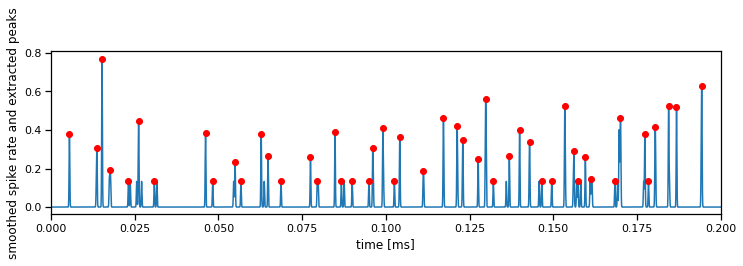

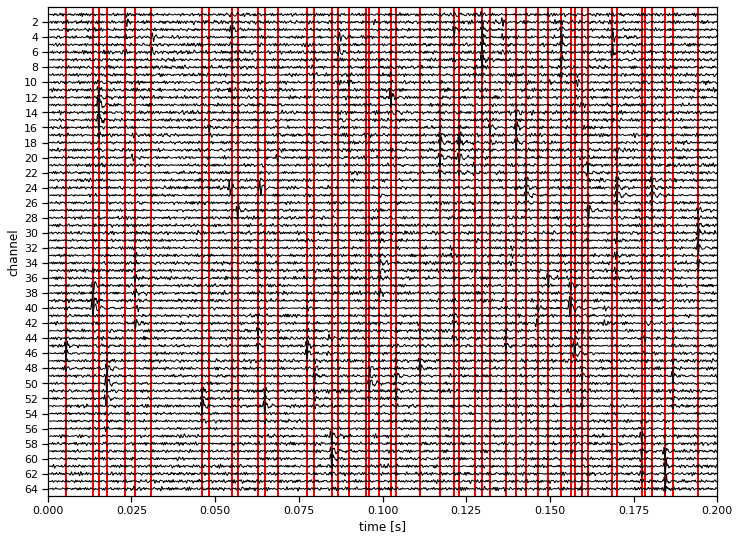

In [ ]:
# Count total number of spikes across all channels in each sample.
bins = np.arange(num_samples + 1)
total_spike_counts, _ = np.histogram(np.concatenate(per_ch_spike_inds), bins=bins)   # YOUR CODE HERE


# Do a little Gaussian smoothing to allow for jitter in spike time across channels
total_spike_counts = gaussian_filter1d(total_spike_counts.astype(float), 0.0001 * sample_freq)

# Eyeball a threshold and find peaks.
# RUN WITH NP.INF FIRST AND THEN
# EYEBALL THE PLOT TO SET A HEIGHT THRESHOLD
# min_height = np.inf 
min_height = 0.1

spike_inds, _ = signal.find_peaks(total_spike_counts, 
                                  height=min_height, 
                                  distance=0.001 * sample_freq)
num_spikes = len(spike_inds)
print("Found", num_spikes, "putative spikes.")

# Plot the smoothed spike counts and extracted spike indices.
plt.figure(figsize=(12, 3))
in_slice = (spike_inds >= plot_slice.start) & (spike_inds < plot_slice.stop) 
plt.plot(timestamps[plot_slice], total_spike_counts[plot_slice])
plt.plot(timestamps[spike_inds[in_slice]], total_spike_counts[spike_inds[in_slice]], 'ro')
plt.xlim([timestamps[plot_slice.start], timestamps[plot_slice.stop]])
plt.xlabel("time [ms]")
plt.ylabel("smoothed spike rate and extracted peaks")

# Plot the data and overlay the spike times to sanity check your results.
plot_data(timestamps, data, scale=10)
plt.vlines(timestamps[spike_inds[in_slice]], *plt.ylim(), color='r', lw=2)


In [ ]:
assert num_spikes == 32115, "Play with the threshold to ensure you get this number of spikes."

## Collect the spikes into an array

For each of the `spike_inds` found above, extract a window of `spike_width` time samples from `data`, centered on the spike and insert it into the `spikes` array.

In [ ]:
spikes = np.zeros((num_spikes, num_channels, spike_width))

for i, ind in enumerate(spike_inds):
    #spikes[i] =  data[:, int(ind - (spike_width)/2): int(ind + (spike_width)/2) ]# YOUR CODE HERE
    # spikes[i] =  data[:, ind-40: ind+40 ]
    spike_width_half = int((spike_width-1)/2)
    spikes[i] =  data[:, (ind-spike_width_half): (ind+spike_width_half+1)]

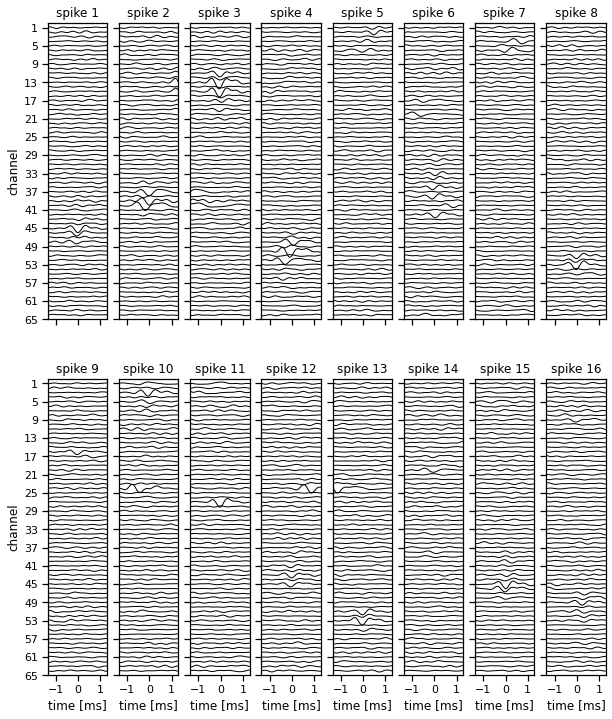

In [ ]:
# We can use our template plotting code to visualize the spikes too.
plot_templates(spikes, indices=np.arange(16), scale=10, label="spike")

# Part 3: Write a simple spike sorting algorithm

Recall our simple spike sorting model from lecture.
Let
- $S$ denote the number of (putative) spikes
- $C$ denote the number of channels on the probe.
- $D$ denote the maximum duration (in frames) of a spike.
- $N$ denote the (unknown) number of units (i.e. neurons).
- $K \leq \min\{C, D\}$ denote the dimensionality (i.e. rank) of a single unit's spike waveform.

Our preprocessing steps above yielded an array of spike waveforms, which we denote by $Y \in \mathbb{R}^{S \times C \times D}$.

Our latent variables are,
- $n_s \in \{1, \ldots, N\}$, the neuron label assigned to spike $s$. 
- $a_s \in \mathbb{R}_+$, the amplitude of spike $s$. 

And our parameters are,
- $W \in \mathbb{R}^{N \times C \times D}$, the normalized waveform of spikes by neuron $n$.
- $\pi \in \Delta_N$, a prior distribution on neurons.

For simplicity, we will treat the following as hyperparameters. Let,
- $\lambda_n \in \mathbb{R}_+$, the rate (inverse scale) of spike amplitudes on neuron $n$.
- $\sigma^2 \in \mathbb{R}_+$, the noise level, which we assume to be constant across channels. 

We will set $\lambda_n = 0.01$ to minimally shrink the amplitude estimates, and we set $\sigma^2 = 1$ based on the standardization we did in preprocessing.


## Problem 3a: write a helper function to project onto $\mathcal{S}_K$.

One of the key pieces of our algorithm is solving the following constrained optimization over $\mathcal{S}_K$,
\begin{align}
X^\star &= \mathrm{argmin}_{X \in \mathcal{S}_K} \mathrm{Tr}(A^\top X)
\end{align}
for a target matrix $A \in \mathbb{R}^{C \times D}$. This is equivalent to projecting $A$ onto the set $\mathcal{S}_K$. In lecture we showed that we can solve this problem with the SVD $A = U \mathrm{diag}(\varsigma) V$. Then, 
\begin{align}
X^\star &= U_{:K} \mathrm{diag} \left(\tfrac{\varsigma_{:K}}{\|\varsigma_{:K}\|_2} \right) V_{:K}^\top,
\end{align}
where $U_{:K}$ and $V_{:K}$ are the first $K$ columns of $U$ and $V$, and where $\varsigma_{:K}$ are the first $K$ singular values in $\varsigma$.

Write a helper function to compute this projection.


In [ ]:
def project_templates(targets, rank):
    """A helper function to project a target template
    onto the space of rank-K, unit norm matrices via
    truncted SVD.

    Parameters:

    targets:    an NxCxD array of target matrices
    rank:       an integer K <= min(C, D)

    Returns:

    templates:  a NxCxD array where templates[n] is the projection
                of targets[n] onto \mathcal{S}_K, the set of rank-K,
                unit norm matrices.
    """
    assert rank <= min(*targets.shape[-2:])
    
    ###
    # Compute the optimal templates using the SVD of the targets.
    #
    # YOUR CODE BELOW
    # U, Sigma, VT = np.linalg.svd(targets, full_matrices=False)

    templates = np.empty(np.shape(targets))
    for n in range(len(targets)):
      U, Sigma, VT = np.linalg.svd(targets[n])
      template = U[:, : rank] @ np.diag(Sigma[: rank] / np.linalg.norm(Sigma[: rank])) @ VT[: rank, :]
      templates[n] = template

    #
    ###
    
    assert np.allclose(np.sum(templates**2, axis=(-1,-2)), 1)
    return templates
  

## Initialize the model parameters

Initialize the model parameters as follows:
- Fix `num_neurons` $N=100$ as an upper bound on the number of neurons
- Fix `template_rank` $K=3$ as the rank of the templates
- Set `amplitude_rates` $\lambda_n = 0.01$ for a broad prior on amplitudes $a_s$
- Set `noise_std` $\sigma = 1$, since we have standardized the data.

- Initialize `templates` $W$ by randomly choosing $N$ spike waveforms from $Y$ and projecting them onto $\mathcal{S}_K$ using the function you write in problem 3a.
- Set `neuron_probs` $\pi$ to the uniform distribution

In [ ]:
# We'll give our variables human-readable names

# Set the hyperparameters
num_neurons = 100                                               # N
template_rank = 3                                               # K
amplitude_rates = 0.01 * np.ones(num_neurons)                   # \lambda_n
noise_std = 1.0                                                 # \sigma

# Initialize colors to plot each neuron
npr.seed(0)
colors = get_cmap("jet")(npr.rand(num_neurons))

# Initialize the model parameters
#
# Set uniform neuron probabilities (1/N, ..., 1/N)
neuron_probs = np.ones(num_neurons) / num_neurons               # \pi

# Initialize the templates W by projecting randomly 
# chosen spike indices.
# Make sure the templates are low rank and normalized!
inds = npr.choice(num_spikes, size=num_neurons, replace=False)
templates = project_templates(spikes[inds], template_rank)      # W

# Initialize the latent variables.
# (These will be overwritten below, but it's helpful to 
#  specification here.)
labels = npr.choice(num_neurons, size=num_spikes)               # n_s
amplitudes = np.ones(num_spikes)                                # a_s

# Pack them into dictionaries
hypers = dict(
    num_neurons=num_neurons,
    template_rank=template_rank,
    amplitude_rates=amplitude_rates,
    noise_std=noise_std
)

params = dict(
    templates=templates,
    neuron_probs=neuron_probs,
)

latents = dict(
    labels=labels,
    amplitudes=amplitudes
)

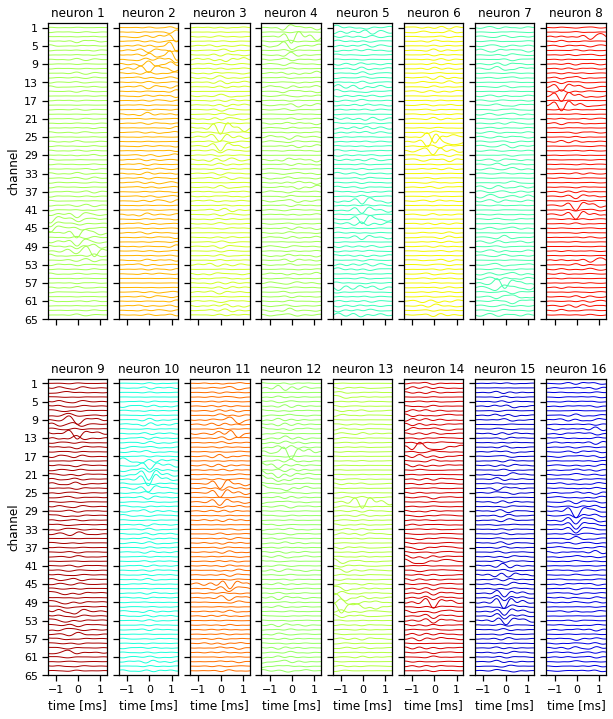

In [ ]:
# Plot the initial templates
plot_templates(params["templates"], np.arange(16), scale=0.1, colors=colors)

## Problem 3b: Write a function to compute the log probability

For the likelihood, we modeled the observed spike waveforms as randomly scaled versions of a neuron's normalized waveform plus additive noise.
\begin{align}
    p(Y \mid W, \{n_s, a_s\}_{s=1}^S, \sigma^2) 
    &= \prod_{s=1}^S \prod_{c=1}^C \prod_{d=1}^D \mathcal{N} \left(y_{scd} \mid a_s \cdot w_{n_s cd}, \, \sigma^2 \right).
\end{align}

Taking the log and expanding the Gaussian density,
\begin{align}
    \log p(Y \mid W, \{n_s, a_s\}_{s=1}^S, \sigma^2) 
    &= 
    \sum_{s=1}^S \sum_{c=1}^C \sum_{d=1}^D 
    \left[-\frac{1}{2} \log 2 \pi \sigma^2 -\frac{1}{2\sigma^2} (y_{scd} - a_s \cdot w_{n_s cd})^2 \right] \\
    &= 
    -\frac{SCD}{2} \log 2\pi\sigma^2 -\frac{1}{2\sigma^2} \sum_{s=1}^S \|Y_s - a_s W_{n_s}\|_F^2 \\
    &= 
    -\frac{SCD}{2} \log 2\pi\sigma^2 -\frac{1}{2\sigma^2} \sum_{n=1}^N \sum_{s:n_s = n} \|Y_s - a_s W_{n}\|_F^2 \\
    &= 
    -\frac{SCD}{2} \log 2\pi\sigma^2 -\frac{1}{2\sigma^2} \sum_{n=1}^N \sum_{s:n_s = n} \sum_{c=1}^C \sum_{d=1}^D (y_{scd} - a_s w_{ncd})^2
\end{align}

We completed the model with priors on the latent variables and parameters. We assumed,
\begin{align}
n_s &\sim \pi \\
a_s \mid n_s &\sim \mathrm{Exp}(\lambda_{n_s})
\end{align}
where $\pi \in \Delta_N$ is a distribution on neurons and $\lambda_n$ is the rate parameter (i.e. the inverse scale) of an exponential distribution on amplitudes. Thus,
\begin{align}
\log p(\{n_s, a_s\}_{s=1}^S) = \sum_{s=1}^S \log \pi_{n_s} + \log \lambda_{n_s} - \lambda_{n_s} a_s.
\end{align}


We assumed uniform priors on $\pi$ and $W_n$, so they will not factor into our log probability calculation.

In [ ]:
def log_probability(spikes, latents, params, hypers):
    """Evaluate the average log joint probability of the spikes, 
    latents, and params.
    """
    S, C, D = spikes.shape
    N = hypers["num_neurons"]
    sigma = hypers["noise_std"]
    lmbdas = hypers["amplitude_rates"]

    ns = latents["labels"]
    amps = latents["amplitudes"]
    W = params["templates"]
    pi = params["neuron_probs"]
    
    ### 
    # Compute the log joint probability.
    # First compute the log likelihood p(Y | \{n_s, a_s\}, W, \sigma).
    # Then compute the log prior p(\{n_s, a_s\}).
    # 
    # YOUR CODE BELOW
    #
    log_lkhd = - S * C * D / 2 * np.log(2 * np.pi * sigma**2)
    log_prior = 0
    for s in range(S):
      log_lkhd += -1 / (2 * sigma**2) * np.linalg.norm(spikes[s] - amps[s] * W[ns[s]])**2
      log_prior += np.log(pi[ns[s]]) + np.log(lmbdas[ns[s]]) - lmbdas[ns[s]] * amps[s]
    
    
    # compute the log prior probability 
    # (consider using stats.expon.logpdf)
    # note from Julia: I tried using the suggested function but I think I'm using it incorrectly because it only does worse
    # log_prior = 0
    # for s in range(S):
    #   log_prior += stats.expon.logpdf(amps[s], scale = 1/lmbdas[ns[s]])

    # note to TAs: prior is calculated in the above loop w/ the likelihood
    ###

    # The log joint is the log likelihood plus the log prior
    log_joint = log_lkhd + log_prior
    
    # return the average log probability 
    return log_joint / spikes.size

lp = log_probability(spikes, latents, params, hypers)
print(lp)

# Gongqi's Comment: I did not get the expected value of -1.5218722, but got -1.5216 instead. 
# There are minor error in my implementation that I could not discovered, so I moved on...
# Anyone find any prob with my code?

# Julia's comment: I redefined the spike window indices above and got it closer to the desired value

-1.5218525667629383


In [ ]:
# Try it! 
lp = log_probability(spikes, latents, params, hypers)
assert np.allclose(lp, -1.5218722,atol=1e-4)

## Problem 3c: Write a function to update for the latent variables

In lecture we derived a coordinate ascent algorithm for MAP estimation of the latent variables and parameters. We showed that for fixed parameters, the optimal spike assignment ($n_s$) and amplitude $a_s$ are,
\begin{align}
n_s &= \mathrm{argmax} \mathcal{L}(n) \\
a_s &= a_s^\star(n_s) 
\end{align}
where
\begin{align}
    a_s^\star(n) &= \max\left\{0, \, \mathrm{Tr}(Y_s^\top W_{n}) - \sigma^2 \lambda_{n} \right\} \\
    \mathcal{L}(n) &=
    \frac{1}{2 \sigma^2}\left( a_s^\star(n) \right)^2  + \log \pi_{n}.
\end{align}
Let's implement this update. Remember that $\mathrm{Tr}(Y_s^\top W_n) = \sum_{cd} Y_{scd} W_{ncd}$.

In [ ]:
def update_latent_variables(spikes, params, hypers):
    """Solve for the optimal labels and amplitudes \{n_s, a_s\}_{s=1}^S
    given the data, the current parameters, and the hyperparameters.

    Returns: a dictionary with keys
        "labels"        a 1d array of spike assignments n_s 
        "amplitudes"    a 1d array of non-negative amplitudes a_s
    """
    Y = spikes
    S, C, D = Y.shape
    lmbda = hypers["amplitude_rates"]
    sigma = hypers["noise_std"]
    W = params["templates"]
    pi = params["neuron_probs"]

    # compute the optimal amplitudes for each spike and assignment
    # the output should be a S by N array
    amplitudes = np.einsum('scd, ncd->sn', Y, W)   # YOUR CODE HERE

    # threshold the amplitudes
    amplitudes = np.maximum(0, amplitudes - sigma**2 * np.tile(lmbda, [S, 1]))    # YOUR CODE HERE

    # compute the score \mathcal{L}(n) for each spike and neuron
    # the output should be a S by N array
    lp = 1 / (2 * sigma**2) * np.einsum('ij, ij->ij', amplitudes, amplitudes) + np.log(np.tile(pi, [S, 1]))

    # find the most likely neuron labels
    labels = np.argmax(lp, axis=1)

    # get the corresponding amplitude
    amplitudes = amplitudes[np.arange(S), labels]
    
    # pack the results into a dictionary and return
    return dict(labels=labels, amplitudes=amplitudes)
  


Text(0, 0.5, 'num. assigned spikes')

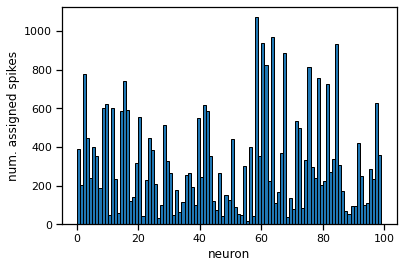

In [ ]:
# Test it! Run one update of the latent variables 
new_latents = update_latent_variables(spikes, params, hypers)

# Plot a histogram of neuron labels
plt.hist(new_latents["labels"], np.arange(num_neurons), ec='k')
plt.xlabel("neuron")
plt.ylabel("num. assigned spikes")

## Problem 3d: Write a function to update the templates

In lecture we showed that the optimal waveforms are the truncated SVD of the average spike waveform,
\begin{align}
    \bar{Y}_n &\propto \sum_{s:n_s = n} a_s Y_s,
\end{align} 
which we call the `targets` in the code below.

Compute this matrix for each neuron $n$ using the current assignments, then use your `project_templates` function to find
\begin{align}
    W_n^\star &= \mathrm{argmax}_{W_n \in \mathcal{S}_K} \mathrm{Tr}(\bar{Y}_n^\top W_n).
\end{align}



In [ ]:
def update_templates(spikes, latents, params, hypers):
    # Unpack the parameters
    S, C, D = spikes.shape
    N = hypers["num_neurons"]
    K = hypers["template_rank"]
    ns = latents["labels"]
    amps = latents["amplitudes"]
    # compute the target for each neuron
    targets = np.zeros((N, C, D))

    # Used the rather inefficient for loop, please update it with einsum if you can.
    # for n in range(N):
    #   for s in range(S):
    #     if(ns[s] == n):
    #       targets[n] += amps[s] * spikes[s]    # YOUR CODE HERE (np.einsum might be helpful again)
          
    # targets = np.zeros((N, C, D))
    for n in range(N):
      inds = (ns == n)
      temp = np.einsum('i,ijk -> ijk', amps[inds],spikes[inds])
      targets[n] = np.einsum('ijk -> jk', temp)

    # solve the constrained optimization problem
    templates = project_templates(targets, K)

    # Update the parameters
    new_params = deepcopy(params)
    new_params["templates"] = templates
    return new_params


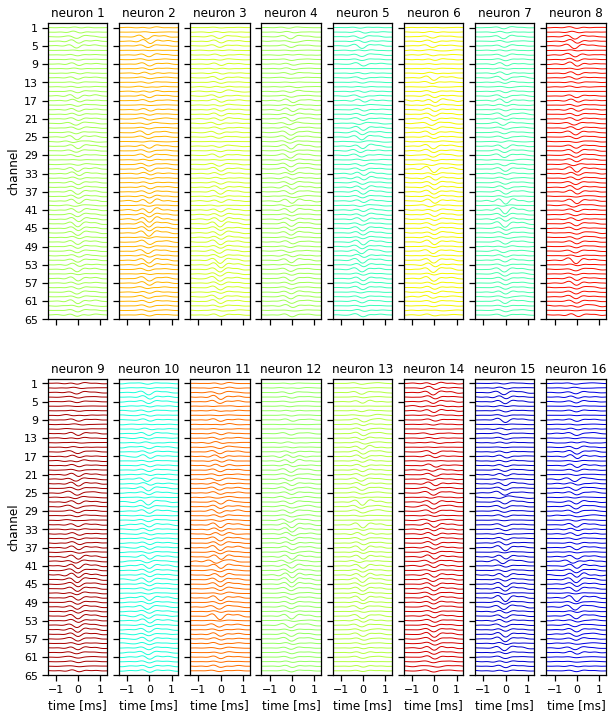

In [ ]:
# Try it! Since we set the neuron assignments randomly, 
# the templates should all look like the average spike waveform.
new_params = update_templates(spikes, latents, params, hypers)
plot_templates(new_params["templates"], np.arange(16), colors=colors)

## Problem 3e: Write a function to update the neuron probabilities $\pi$

In lecture you worked out that,
\begin{align}
\pi_n &= \frac{1}{S} \sum_{s=1}^S \mathbb{I}[n_s = n].
\end{align}


In [ ]:
def update_neuron_probs(spikes, latents, params, hypers):
    num_spikes = spikes.shape[0]
    labels = latents["labels"]

    # Find the optimal neuron probabilities
    pi = 1 / num_spikes * np.bincount(labels)    # YOUR CODE HERE (try np.bincount)
    
    # Return a new copy of the parameters
    new_params = deepcopy(params)
    new_params["neuron_probs"] = pi
    return new_params

## Optional: Update the amplitude rates $\lambda_n$
See the lecture slides for a final form. If you write a function fo this step, call it in `update_parameters` below. In practice, you should get fine results even with $\lambda_n$ fixed to 0.01, as it is currently.

In [ ]:
def update_lmbda(spikes, latents, params, hypers):
    """Update the neuron assignment probabilites $\pi$, holding
    the latent variables fixed.
    """
    S, C, D = spikes.shape
    N = hypers["num_neurons"]
    ns = latents["labels"]
    amps = latents["amplitudes"]

    Sn = np.bincount(ns)

    lmbda = np.zeros([N, 1])

    # The usage of for loop is rather inefficient, will change it later
    for n in range(N):
      for s in range(S):
        if(ns[s] == n):
          lmbda[n] += amps[s] / Sn[n]

    lmbda = np.reciprocal(lmbda)
    # Return a new copy of the parameters
    new_hypers = deepcopy(hypers)
    new_hypers["amplitude_rates"] = lmbda
    return new_hypers

## Put it all together

Now we can write a function to perform MAP estimation.

**No coding necessary for this block**

In [ ]:
def update_parameters(spikes, latents, params, hypers):
    params = update_templates(spikes, latents, params, hypers)
    params = update_neuron_probs(spikes, latents, params, hypers)
    return params

def map_estimate(spikes, 
                 initial_latents,
                 initial_params, 
                 hypers, 
                 max_iter=10,
                 tol=1e-3):
    """Find the MAP estimate of the parameters and latent
    variables via coordinate ascent.
    """
    # Initialize the algorithm
    latents = initial_latents
    params = initial_params
    lps = [log_probability(spikes, latents, params, hypers)]

    pbar = trange(max_iter)
    pbar.set_description("LP: {:.4f}".format(lps[0]))
    for itr in pbar:
        # compute the most likely latent variables given current parameters
        latents = update_latent_variables(spikes, params, hypers)
        
        # compute the most likely parameters given the latent variables
        params = update_parameters(spikes, latents, params, hypers)

        # compute the new log probability
        lps.append(log_probability(spikes, latents, params, hypers))
        
        # update the progress bar
        pbar.update(1)
        pbar.set_description("LP: {:.4f}".format(lps[-1]))
        
        # check for convergence
        if abs(lps[-1] - lps[-2]) < tol:
            print("Convergence detected!")
            break

    return np.array(lps), latents, params

Convergence detected!


Text(0, 0.5, 'log probability')

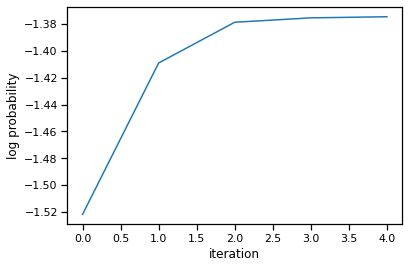

In [ ]:
lps, latents, new_params = map_estimate(spikes, latents, params, hypers)

# Plot the training curve
plt.plot(lps)
plt.xlabel("iteration")
plt.ylabel("log probability")

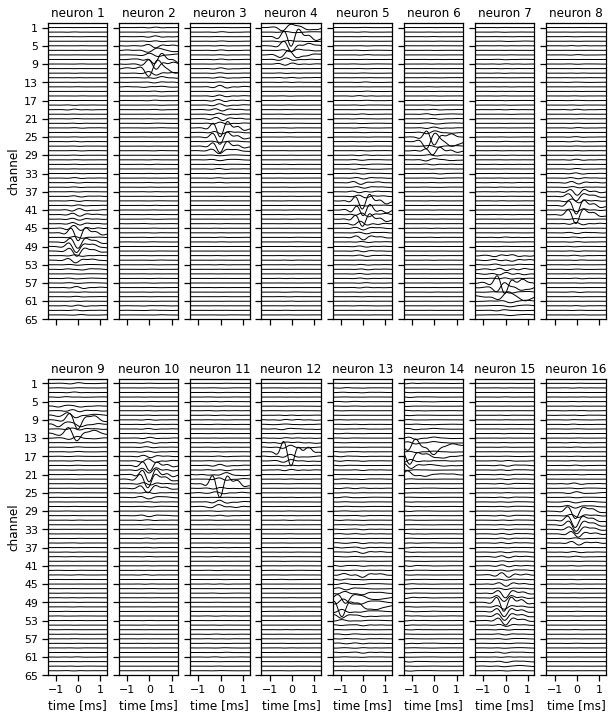

In [ ]:
# Plot some of the learned templates
plot_templates(new_params["templates"], np.arange(16))

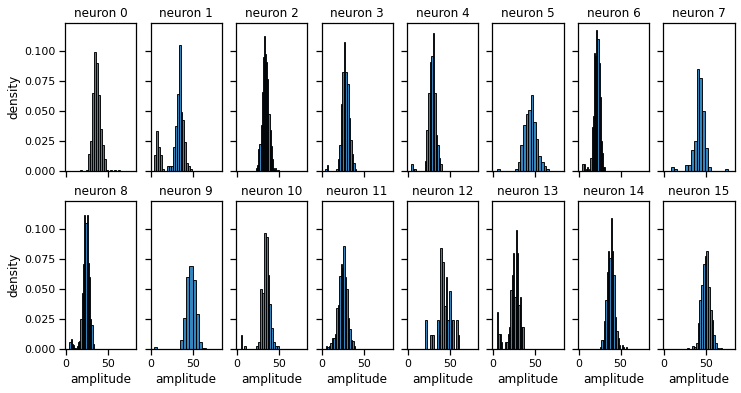

In [ ]:
# Plot the amplitude distributions for a few neurons
def plot_amplitudes(latents, n_rows=2, n_cols=8):
    labels = latents["labels"]
    amps = latents["amplitudes"]

    fig, axs = plt.subplots(n_rows, n_cols, sharex=True, sharey=True, 
                            figsize=(12, 6))
    for ind, ax in enumerate(np.ravel(axs)):
        row, col = np.unravel_index(ind, (n_rows, n_cols))
        ax.hist(amps[labels==ind], 20, density=True, edgecolor='k', alpha=0.9)
    
        if row == n_rows - 1:
            ax.set_xlabel("amplitude")
        if col == 0:
            ax.set_ylabel("density")
        ax.set_title("neuron {}".format(ind))

plot_amplitudes(latents)

You'll probably see some bimodal amplitude histograms. These suggest that some labels actually correspond to multiple true neurons.  In the next section we'll do some basic evaluation of the model outputs.

# Part 4: Evaluation

Compare the inferred spike assignments to the ground truth. 

**There is no coding necessary for this part. Instead, you will be asked to discuss ways that you could further evaluate the spike sorting algorithm.**

In [ ]:
# Load the ground truth labels
ground_truth = loadmat("eMouseGroundTruth.mat", squeeze_me=True)
true_labels = ground_truth["gtClu"]
true_inds = ground_truth["gtRes"]
num_true_neurons = true_labels.max()

## See how close our inferred spike times are to the true times 

We've written some basic code to check how close the inferred spikes are to the true spike times.  Note that the true spike times are defined as the start of the template, whereas ours are defined as the center. Even after accounting for that, there could be a little offset since we haven't forced our templates to peak in the middle, but we should expect that the time to the nearest true spike should be on the order of a spike width, say 1ms.

number of inferred spikes more than 5ms away from a true spike:  2


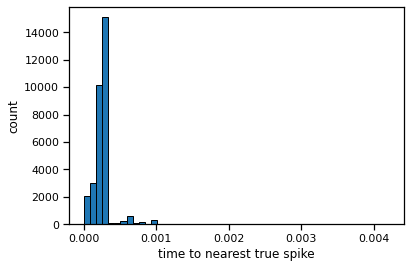

In [ ]:
nn = NearestNeighbors(1).fit(true_inds.reshape(-1, 1))
dists, nearest_inds = nn.kneighbors((spike_inds - spike_width // 2).reshape(-1, 1))
dists, nearest_inds = dists.ravel(), nearest_inds.ravel()
dists_sec = dists.ravel() / sample_freq
nearest_times = true_inds[nearest_inds.ravel()]

plt.hist(dists_sec[dists_sec < 0.005], 50, ec='k')
plt.xlabel("time to nearest true spike")
plt.ylabel("count")
print("number of inferred spikes more than 5ms away from a true spike: ", np.sum(dists_sec > 0.005))

## See how well our inferred labels line up with the true labels

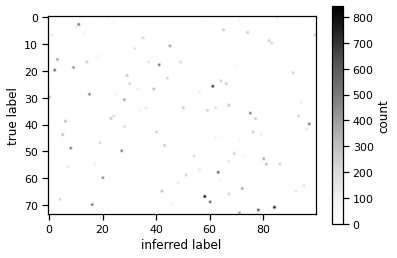

In [ ]:
# First get the label of the nearest true spike
nearest_labels = true_labels[nearest_inds]
num_neurons_true = len(np.unique(true_labels))

# Then compute the overlap matrix, which counts the number of times 
# a spike with true label i was assigned label j by our algorithm.
def compute_overlap(labels, true_labels):
    unique_labels = np.unique(labels)
    unique_true_labels = np.unique(true_labels)

    overlap = np.zeros((len(unique_true_labels), len(unique_labels)))
    for i, label_i in enumerate(unique_true_labels):
        for j, label_j in enumerate(unique_labels):
            overlap[i, j] = np.sum((true_labels == label_i) & (labels == label_j))
    return overlap, unique_labels, unique_true_labels

overlap, _, _ = compute_overlap(latents["labels"], nearest_labels)

plt.imshow(overlap, cmap="Greys")
plt.xlabel("inferred label")
plt.ylabel("true label")
plt.colorbar(label="count")


## The labels are all shuffled! Use a simple heuristic to align them.
We permute the inferred labels by finding the true label with the most overlap and then sorting.

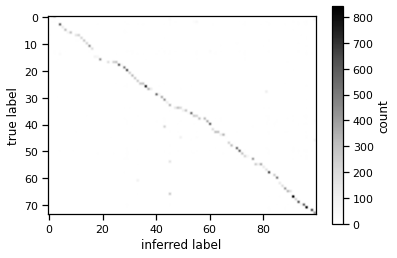

In [ ]:
# Permute the inferred labels to align with the true labels
permutation = np.argsort(np.argmax(overlap, axis=0))

plt.imshow(overlap[:, permutation], cmap="Greys")
plt.xlabel("inferred label")
plt.ylabel("true label")
plt.colorbar(label="count")

We should see a nice diagonal band, indicating that a close correspondence between true and inferred labels.

## Problem 4a: Discuss evaluation methods for spike sorting.

These sanity checks suggest that the algorithm is finding real spike clusters, at least in this synthetic data. Discuss other ways you could evaluate the algorithm:

- How surprised should we be by these overlap matrices? Can you think of ways to get a reasonable baseline?

- In real data we don't have the ground truth spike times or assignments. What types of checks would you do to assess model performance?

*Answer below this line*

---
1. We aren't surprised by these overlap matrices because the templates are learned from the data, so it makes sense that they would match. The overlap matrix currently shows that our algorithm learned relatively accurate labels of the spikes. If an algorithm was working properly and there were equal numbers of true labels and inferred labels, the overlap matrix would show a diagonal line of correspondence between the labels, showing that the algorithm is learning the true labeling from the data. Therefore, our reasonable baseline to aim for would be this diagonal line.

2. We would create a similar plot to the above spike-finding plot, to check visually that our model is identifying peaks on a small portion of the data. In addition, we could analyze the waveforms of the generated template to make sure that they look like real waves. We could also check whether the same neuron's spikes show up on the consistent channels, since the neuron shouldn't move around during data collection. Finally, we could consider the refractory period of neurons -- if a neuron shows two spikes within its refractory period, this is suspicious and may be evidence of a faulty algorithm. 


## Problem 4b: Discuss limitations of this modeling approach

- How realistic are these modeling assumptions? Are there any assumptions that are clearly not appropriate for this data?

- What are the possible effects of such model misspecification? 

- What were some of the key hyperparameters and how you would expect different hyperparameter settings to affect your results?

*Answer below this line*

---
1. For the probabolistic model, we are assuming that the templates are low rank, and that Wn (magnitude of templates) is uniformely distributed on set of rank-K, unit norm matrices. We are also drawing spike timing and noise from known distributions. In addition, we assume that each waveform comes from a single neuron, and that the variability introduced into the data only comes from scaling these waveforms, not doing any other transformations.
2. There is a clear issue that arises from our assumption that each waveform comes from a single neuron, namely, that it assumes only one neuron can fire during each spike window. From class on Wednesday, we calculated that this is highly unlikely. So, this could lead to us undercounting the number of spikes that occur, or we could underestimate how many neurons are firing over a specific time window. We also assume that the only variability in the data comes from scaling our waveforms, which implicitly assumes that these neurons can't vary the time-scale (or other properties) of their spikes.
3. Key hyperparameters:  
$𝜆_𝑛$ (rate of spike amplitudes on neuron n) = .01,   
$𝜎^2$ (noise level) = 1,  
$N$ (number of neurons) = 100,  
$K$ (template rank) = 3.  
If we were to underestimate the number of neurons $N$, we would likely label spikes from distinct neurons with the same label. Conversely, if we make $N$ too large this leads to multiple labels corresponding to the same true neuron. If we made the noise level $\sigma^2$ too large this could lead us to ignoring some smaller spikes, and if we made it too small we might include some spikes that weren't part of the data. However, since we standardized the data we know what $\sigma$ should be. If we chose not to update the $\lambda_n$s and made the prior too skinny, we could have ignored some of the actual spike amplitude rates.

# Submission instructions
Create a GradeScope account with your Stanford email address , if you don't already have one. You should have access to the STATS320 course on GradeScope if you're enrolled in STATS320, STATS220, CS339N, or NBIO220. Let us know if you don't see it!

- Print to PDF and download an .ipynb file. 
- Submit both on GradeScope